#basic

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os

# Define the path to your folder in Google Drive
folder_path = '/content/drive/My Drive/IoMT'

# List all files in the directory
files = os.listdir(folder_path)
print(files)

Mounted at /content/drive
['ARP Spoofing', 'Benign', 'MQTT Attacks', 'Reconnaissance Attacks', 'TCP&IP Attacks', 'iomt.ipynb', 'iomttabnet.ipynb']


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.9 MB/s eta 0:00:00


In [ ]:
!pip install wandb -qU

In [ ]:
import wandb
import random
import math

In [ ]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

#TCP IP-DDoS-ICMP1

In [ ]:
#1
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from catboost import CatBoostClassifier

# Define paths for training and test datasets
train_file_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/TCP_IP-DDoS-ICMP1_train.pcap.csv'
test_file_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/TCP_IP-DDoS-ICMP1_test.pcap.csv'
model_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/catboost_icmp1_model.cbm'

# Load datasets
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# Drop missing values
train_data = train_data.dropna()
test_data = test_data.dropna()

# Normalize the datasets
scaler = StandardScaler()
train_data_normalized = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns)
test_data_normalized = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)

# Identify columns for anomaly detection
columns_to_check = ['Rate', 'Duration', 'Header_Length', 'Srate', 'Drate']

# Calculate Z-scores
z_scores_train = np.abs(train_data_normalized[columns_to_check].apply(lambda x: (x - x.mean()) / x.std()))
z_scores_test = np.abs(test_data_normalized[columns_to_check].apply(lambda x: (x - x.mean()) / x.std()))

# Define threshold for anomalies (e.g., 3 standard deviations)
threshold = 3

# Create an 'is_anomaly' column
train_data_normalized['is_anomaly'] = (z_scores_train > threshold).any(axis=1).astype(int)
test_data_normalized['is_anomaly'] = (z_scores_test > threshold).any(axis=1).astype(int)

# Separate features (X) and labels (y)
X_train = train_data_normalized.drop('is_anomaly', axis=1)
y_train = train_data_normalized['is_anomaly']
X_test = test_data_normalized.drop('is_anomaly', axis=1)
y_test = test_data_normalized['is_anomaly']

# Initialize and train CatBoostClassifier
catboost_clf = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=10, eval_metric='Accuracy', verbose=100, random_seed=42)
catboost_clf.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# Save the trained model
catboost_clf.save_model(model_path)

# Evaluate on test data
y_pred = catboost_clf.predict(X_test)
print("Test Set Performance:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Save results
test_data_normalized['predicted_anomaly'] = y_pred
output_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/TCP_IP_DDoS_ICMP1_test_with_anomalies_catboost.csv'
test_data_normalized.to_csv(output_path, index=False)

# Print anomaly summary
anomalies_count = test_data_normalized['predicted_anomaly'].sum()
print(f'Number of anomalies detected in the test data: {anomalies_count}')

0:	learn: 0.9988920	test: 0.9865720	best: 0.9865720 (0)	total: 281ms	remaining: 2m 20s
100:	learn: 1.0000000	test: 0.9878902	best: 0.9879161 (4)	total: 33.5s	remaining: 2m 12s
200:	learn: 1.0000000	test: 0.9878902	best: 0.9879161 (4)	total: 57.2s	remaining: 1m 25s
300:	learn: 1.0000000	test: 0.9878902	best: 0.9879161 (4)	total: 1m 20s	remaining: 53.5s
400:	learn: 1.0000000	test: 0.9878902	best: 0.9879161 (4)	total: 1m 43s	remaining: 25.6s
499:	learn: 1.0000000	test: 0.9878902	best: 0.9879161 (4)	total: 2m 22s	remaining: 0us

bestTest = 0.9879161337
bestIteration = 4

Shrink model to first 5 iterations.
Test Set Performance:
[[149781    919]
 [   942   2365]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    150700
           1       0.72      0.72      0.72      3307

    accuracy                           0.99    154007
   macro avg       0.86      0.85      0.86    154007
weighted avg       0.99      0.99      0.99    154007

Number

In [ ]:
#2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import numpy as np

# Build Generator
def build_generator(input_dim, output_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dense(256, activation='relu'),
        Dense(output_dim, activation='tanh')
    ])
    return model

# Build Discriminator
def build_discriminator(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Dimensions
input_dim = X_train.shape[1]
output_dim = X_train.shape[1]

# Initialize Generator and Discriminator
generator = build_generator(input_dim, output_dim)
discriminator = build_discriminator(output_dim)
discriminator.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

# Build and Compile GAN
gan = Sequential([generator, discriminator])
gan.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy')

# Train GAN
num_epochs = 100
batch_size = 64

for epoch in range(num_epochs):
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_data = X_train.iloc[idx].values

    # Generate fake data
    noise = np.random.normal(0, 1, (batch_size, input_dim))
    fake_data = generator.predict(noise)

    # Train discriminator
    d_loss_real = discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_data, np.zeros((batch_size, 1)))

    # Train generator
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Discriminator Loss: {d_loss_real[0]}, Generator Loss: {g_loss}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
Epoch 0, Discriminator Loss: 0.7790893912315369, Generator Loss: [array(0.6979207, dtype=float32), array(0.6979207, dtype=float32), array(0.78125, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 10, Discriminator Loss: 0.6852753758430481, Generator Loss: [array(0.6898924, dtype=float32), array(0.6898924, dtype=float32), array(0.6036932, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 20, Discriminator Loss: 0.6896327137947083, Generator Loss: [array(0.6954261, dtype=float32), array(0.6954

  0%|          | 0/100 [00:00<?, ?it/s]

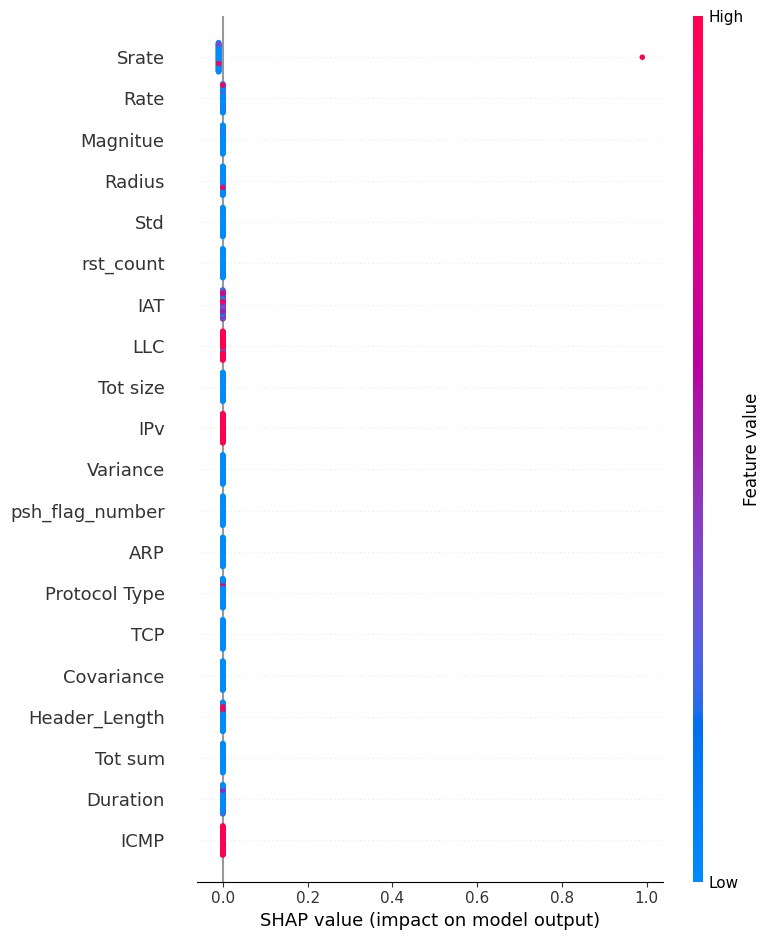

In [ ]:
#3
import shap

# Subset of test data for SHAP
subset_size = 100
subset_indices = np.random.choice(X_test.shape[0], subset_size, replace=False)
X_test_subset = X_test.iloc[subset_indices]

# Initialize SHAP KernelExplainer
explainer = shap.KernelExplainer(catboost_clf.predict, X_test_subset)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_subset)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test_subset)

In [ ]:
#4
# Predict anomalies for the subset
y_pred_subset = catboost_clf.predict(X_test_subset)

# Combine SHAP and predictions
shap_df = pd.DataFrame(shap_values, columns=[f"Feature_{i}" for i in range(X_test_subset.shape[1])])
shap_df['Prediction'] = y_pred_subset
shap_df['True_Label'] = y_test.iloc[subset_indices].values

# Save SHAP results
output_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/catboost_shap_results_icmp1.csv'
shap_df.to_csv(output_path, index=False)

print("SHAP explanations and predictions saved to:", output_path)

SHAP explanations and predictions saved to: /content/drive/My Drive/IoMT/TCP&IP Attacks/catboost_shap_results_icmp1.csv


#TCP IP-DDoS-ICMP2

In [ ]:
#1
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from catboost import CatBoostClassifier

# Define paths for training and test datasets
train_file_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/TCP_IP-DDoS-ICMP2_train.pcap.csv'
test_file_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/TCP_IP-DDoS-ICMP2_test.pcap.csv'
model_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/catboost_icmp2_model.cbm'

# Load datasets
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# Drop missing values
train_data = train_data.dropna()
test_data = test_data.dropna()

# Normalize the datasets
scaler = StandardScaler()
train_data_normalized = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns)
test_data_normalized = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)

# Identify columns for anomaly detection
columns_to_check = ['Rate', 'Duration', 'Header_Length', 'Srate', 'Drate']

# Calculate Z-scores
z_scores_train = np.abs(train_data_normalized[columns_to_check].apply(lambda x: (x - x.mean()) / x.std()))
z_scores_test = np.abs(test_data_normalized[columns_to_check].apply(lambda x: (x - x.mean()) / x.std()))

# Define threshold for anomalies (e.g., 3 standard deviations)
threshold = 3

# Create an 'is_anomaly' column
train_data_normalized['is_anomaly'] = (z_scores_train > threshold).any(axis=1).astype(int)
test_data_normalized['is_anomaly'] = (z_scores_test > threshold).any(axis=1).astype(int)

# Separate features (X) and labels (y)
X_train = train_data_normalized.drop('is_anomaly', axis=1)
y_train = train_data_normalized['is_anomaly']
X_test = test_data_normalized.drop('is_anomaly', axis=1)
y_test = test_data_normalized['is_anomaly']

# Initialize and train CatBoostClassifier
catboost_clf = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=10, eval_metric='Accuracy', verbose=100, random_seed=42)
catboost_clf.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# Save the trained model
catboost_clf.save_model(model_path)

# Evaluate on test data
y_pred = catboost_clf.predict(X_test)
print("Test Set Performance:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Save results
test_data_normalized['predicted_anomaly'] = y_pred
output_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/TCP_IP_DDoS_ICMP1_test_with_anomalies_catboost.csv'
test_data_normalized.to_csv(output_path, index=False)

# Print anomaly summary
anomalies_count = test_data_normalized['predicted_anomaly'].sum()
print(f'Number of anomalies detected in the test data: {anomalies_count}')

0:	learn: 0.9987886	test: 0.9858196	best: 0.9858196 (0)	total: 211ms	remaining: 1m 45s
100:	learn: 0.9999949	test: 0.9842099	best: 0.9858196 (0)	total: 18.2s	remaining: 1m 11s
200:	learn: 0.9999949	test: 0.9842048	best: 0.9858196 (0)	total: 37.4s	remaining: 55.6s
300:	learn: 0.9999949	test: 0.9842048	best: 0.9858196 (0)	total: 1m	remaining: 40.1s
400:	learn: 0.9999949	test: 0.9842048	best: 0.9858196 (0)	total: 1m 22s	remaining: 20.3s
499:	learn: 0.9999949	test: 0.9842048	best: 0.9858196 (0)	total: 2m 5s	remaining: 0us

bestTest = 0.9858195532
bestIteration = 0

Shrink model to first 1 iterations.
Test Set Performance:
[[188736      7]
 [  2768   4181]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    188743
           1       1.00      0.60      0.75      6949

    accuracy                           0.99    195692
   macro avg       0.99      0.80      0.87    195692
weighted avg       0.99      0.99      0.98    195692

Number of an

In [ ]:
#2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import numpy as np

# Build Generator
def build_generator(input_dim, output_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dense(256, activation='relu'),
        Dense(output_dim, activation='tanh')
    ])
    return model

# Build Discriminator
def build_discriminator(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Dimensions
input_dim = X_train.shape[1]
output_dim = X_train.shape[1]

# Initialize Generator and Discriminator
generator = build_generator(input_dim, output_dim)
discriminator = build_discriminator(output_dim)
discriminator.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

# Build and Compile GAN
gan = Sequential([generator, discriminator])
gan.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy')

# Train GAN
num_epochs = 100
batch_size = 64

for epoch in range(num_epochs):
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_data = X_train.iloc[idx].values

    # Generate fake data
    noise = np.random.normal(0, 1, (batch_size, input_dim))
    fake_data = generator.predict(noise)

    # Train discriminator
    d_loss_real = discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_data, np.zeros((batch_size, 1)))

    # Train generator
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Discriminator Loss: {d_loss_real[0]}, Generator Loss: {g_loss}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 0, Discriminator Loss: 0.7002015113830566, Generator Loss: [array(0.7020395, dtype=float32), array(0.7020395, dtype=float32), array(0.578125, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 10, Discriminator Loss: 0.7076147794723511, Generator Loss: [array(0.7154169, dtype=float32), array(0.7154169, dtype=float32), array(0.4971591, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━

  0%|          | 0/100 [00:00<?, ?it/s]

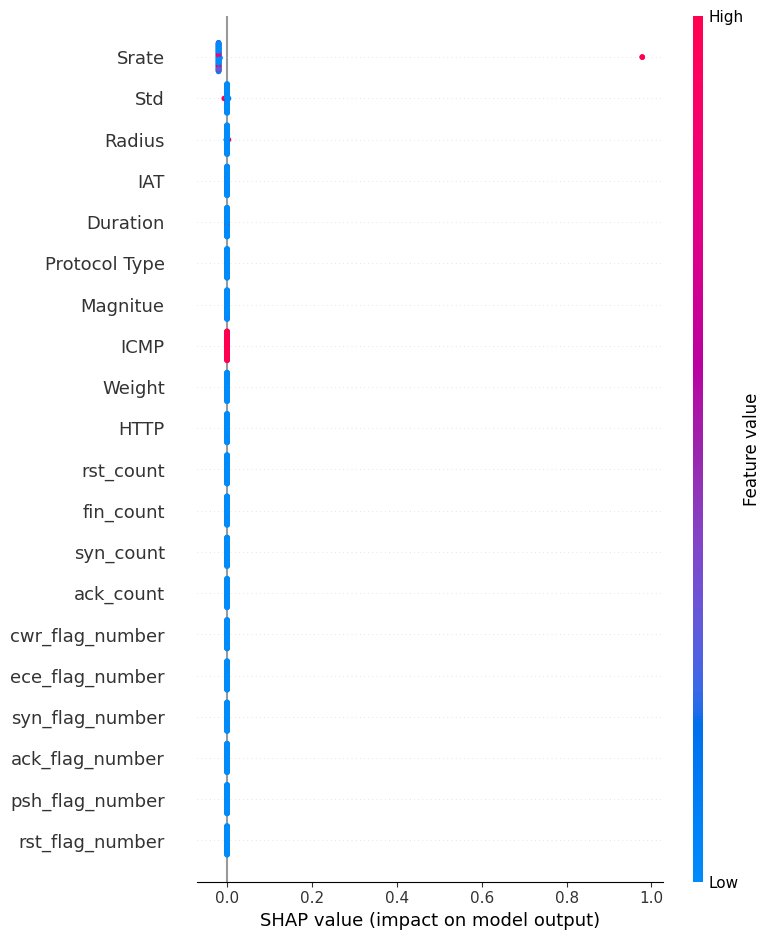

In [ ]:
#3
import shap

# Subset of test data for SHAP
subset_size = 100
subset_indices = np.random.choice(X_test.shape[0], subset_size, replace=False)
X_test_subset = X_test.iloc[subset_indices]

# Initialize SHAP KernelExplainer
explainer = shap.KernelExplainer(catboost_clf.predict, X_test_subset)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_subset)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test_subset)

In [ ]:
#4
# Predict anomalies for the subset
y_pred_subset = catboost_clf.predict(X_test_subset)

# Combine SHAP and predictions
shap_df = pd.DataFrame(shap_values, columns=[f"Feature_{i}" for i in range(X_test_subset.shape[1])])
shap_df['Prediction'] = y_pred_subset
shap_df['True_Label'] = y_test.iloc[subset_indices].values

# Save SHAP results
output_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/catboost_shap_results_icmp1.csv'
shap_df.to_csv(output_path, index=False)

print("SHAP explanations and predictions saved to:", output_path)

SHAP explanations and predictions saved to: /content/drive/My Drive/IoMT/TCP&IP Attacks/catboost_shap_results_icmp1.csv


#TCP IP-DDoS-SYN

In [ ]:
#1
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from catboost import CatBoostClassifier

# Define paths for training dataset and model saving
train_file_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/TCP_IP-DoS-SYN1_train.pcap.csv'
test_file_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/TCP_IP-DoS-SYN_test.pcap.csv'
model_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/catboost_ddos_syn_model.cbm'
# Load datasets
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# Check for missing values and drop them
train_data = train_data.dropna()
test_data = test_data.dropna()

# Normalize the dataset using StandardScaler
scaler = StandardScaler()
train_data_normalized = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns)
test_data_normalized = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)

# Identify columns for anomaly detection
columns_to_check = ['Rate', 'Duration', 'Header_Length', 'Srate', 'Drate']

# Calculate Z-scores for anomaly detection
z_scores_train = np.abs(train_data_normalized[columns_to_check].apply(lambda x: (x - x.mean()) / x.std()))
z_scores_test = np.abs(test_data_normalized[columns_to_check].apply(lambda x: (x - x.mean()) / x.std()))

# Define threshold for anomaly (e.g., 3 standard deviations from the mean)
threshold = 3

# Create an 'is_anomaly' column based on z-scores
train_data_normalized['is_anomaly'] = (z_scores_train > threshold).any(axis=1).astype(int)
test_data_normalized['is_anomaly'] = (z_scores_test > threshold).any(axis=1).astype(int)

# Separate features (X) from the target ('is_anomaly')
X_train = train_data_normalized.drop('is_anomaly', axis=1)
y_train = train_data_normalized['is_anomaly']
X_test = test_data_normalized.drop('is_anomaly', axis=1)
y_test = test_data_normalized['is_anomaly']

# Initialize CatBoostClassifier
catboost_clf = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=10, loss_function='Logloss', eval_metric='Accuracy', verbose=100, random_seed=42)

# Train the CatBoost model
catboost_clf.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# Save the trained model
catboost_clf.save_model(model_path)

# Predict on the test set
y_pred = catboost_clf.predict(X_test)

# Evaluate the model
print("Test Set Performance")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Save the results with anomaly column added
test_data_normalized['predicted_anomaly'] = y_pred
output_path = '/content/drive/My Drive/IoMT/Reconnaissance Attacks/ddos_syn_test_with_anomalies_catboost.csv'
test_data_normalized.to_csv(output_path, index=False)

# Print a summary of detected anomalies
anomalies_count = test_data_normalized['predicted_anomaly'].sum()
print(f'Number of anomalies detected in the test data: {anomalies_count}')

0:	learn: 0.9970026	test: 0.9804453	best: 0.9804453 (0)	total: 426ms	remaining: 3m 32s
100:	learn: 0.9999821	test: 0.9804453	best: 0.9804453 (0)	total: 28.5s	remaining: 1m 52s
200:	learn: 1.0000000	test: 0.9804453	best: 0.9804453 (0)	total: 58.1s	remaining: 1m 26s
300:	learn: 1.0000000	test: 0.9804453	best: 0.9804453 (0)	total: 1m 20s	remaining: 53s
400:	learn: 1.0000000	test: 0.9804453	best: 0.9804453 (0)	total: 1m 47s	remaining: 26.6s
499:	learn: 1.0000000	test: 0.9804453	best: 0.9804453 (0)	total: 2m 15s	remaining: 0us

bestTest = 0.9804452558
bestIteration = 0

Shrink model to first 1 iterations.
Test Set Performance
[[96667     0]
 [ 1928     0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     96667
           1       0.00      0.00      0.00      1928

    accuracy                           0.98     98595
   macro avg       0.49      0.50      0.50     98595
weighted avg       0.96      0.98      0.97     98595

Number of anomalies detected in the test data: 0


In [ ]:
#2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import numpy as np

# Build Generator
def build_generator(input_dim, output_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dense(256, activation='relu'),
        Dense(output_dim, activation='tanh')
    ])
    return model

# Build Discriminator
def build_discriminator(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Dimensions
input_dim = X_train.shape[1]
output_dim = X_train.shape[1]

# Initialize Generator and Discriminator
generator = build_generator(input_dim, output_dim)
discriminator = build_discriminator(output_dim)
discriminator.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

# Build and Compile GAN
gan = Sequential([generator, discriminator])
gan.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy')

# Train GAN
num_epochs = 100
batch_size = 64

for epoch in range(num_epochs):
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_data = X_train.iloc[idx].values

    # Generate fake data
    noise = np.random.normal(0, 1, (batch_size, input_dim))
    fake_data = generator.predict(noise)

    # Train discriminator
    d_loss_real = discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_data, np.zeros((batch_size, 1)))

    # Train generator
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Discriminator Loss: {d_loss_real[0]}, Generator Loss: {g_loss}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
Epoch 0, Discriminator Loss: 0.7081135511398315, Generator Loss: [array(0.6941036, dtype=float32), array(0.6941036, dtype=float32), array(0.4609375, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 10, Discriminator Loss: 0.6781603693962097, Generator Loss: [array(0.69020414, dtype=float32), array(0.69020414, dtype=float32), array(0.49360797, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 20, Discriminator Loss: 0.6998811364173889, Generator Loss: [array(0.7103442, dtype=float32), array(0.

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:2299: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:2300: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:2299: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:2300: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:2299: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_

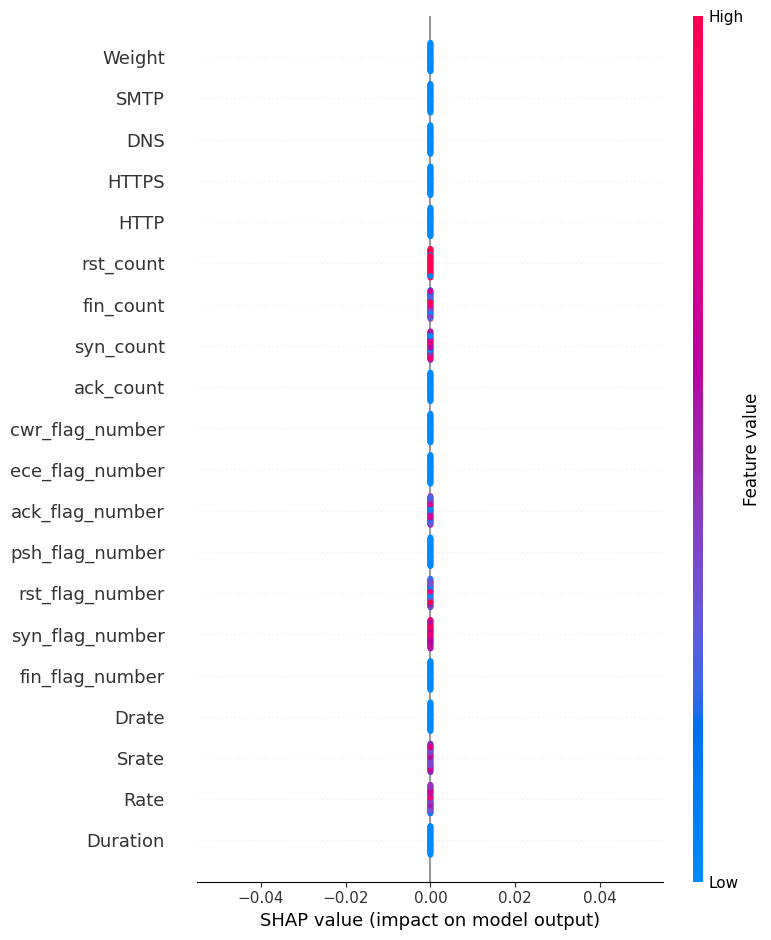

In [ ]:
#3
import shap

# Subset of test data for SHAP
subset_size = 100
subset_indices = np.random.choice(X_test.shape[0], subset_size, replace=False)
X_test_subset = X_test.iloc[subset_indices]

# Initialize SHAP KernelExplainer
explainer = shap.KernelExplainer(catboost_clf.predict, X_test_subset)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_subset)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test_subset)

In [ ]:
#4
# Predict anomalies for the subset
y_pred_subset = catboost_clf.predict(X_test_subset)

# Combine SHAP and predictions
shap_df = pd.DataFrame(shap_values, columns=[f"Feature_{i}" for i in range(X_test_subset.shape[1])])
shap_df['Prediction'] = y_pred_subset
shap_df['True_Label'] = y_test.iloc[subset_indices].values

# Save SHAP results
output_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/catboost_shap_results_ddos_syn.csv'
shap_df.to_csv(output_path, index=False)

print("SHAP explanations and predictions saved to:", output_path)

SHAP explanations and predictions saved to: /content/drive/My Drive/IoMT/TCP&IP Attacks/catboost_shap_results_icmp1.csv


#TCP_IP-DDoS-TCP

In [ ]:
#1
train_file_path = ''
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from catboost import CatBoostClassifier

# Define paths for training and test datasets
train_file_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/TCP_IP-DDoS-TCP1_train.pcap.csv'
test_file_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/TCP_IP-DDoS-TCP_test.pcap.csv'
model_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/catboost_ddos_tcp_model.cbm'

# Load datasets
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# Drop missing values
train_data = train_data.dropna()
test_data = test_data.dropna()

# Normalize the datasets
scaler = StandardScaler()
train_data_normalized = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns)
test_data_normalized = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)

# Identify columns for anomaly detection
columns_to_check = ['Rate', 'Duration', 'Header_Length', 'Srate', 'Drate']

# Calculate Z-scores
z_scores_train = np.abs(train_data_normalized[columns_to_check].apply(lambda x: (x - x.mean()) / x.std()))
z_scores_test = np.abs(test_data_normalized[columns_to_check].apply(lambda x: (x - x.mean()) / x.std()))

# Define threshold for anomalies (e.g., 3 standard deviations)
threshold = 3

# Create an 'is_anomaly' column
train_data_normalized['is_anomaly'] = (z_scores_train > threshold).any(axis=1).astype(int)
test_data_normalized['is_anomaly'] = (z_scores_test > threshold).any(axis=1).astype(int)

# Separate features (X) and labels (y)
X_train = train_data_normalized.drop('is_anomaly', axis=1)
y_train = train_data_normalized['is_anomaly']
X_test = test_data_normalized.drop('is_anomaly', axis=1)
y_test = test_data_normalized['is_anomaly']

# Initialize and train CatBoostClassifier
catboost_clf = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=10, eval_metric='Accuracy', verbose=100, random_seed=42)
catboost_clf.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# Save the trained model
catboost_clf.save_model(model_path)

# Evaluate on test data
y_pred = catboost_clf.predict(X_test)
print("Test Set Performance:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Save results
test_data_normalized['predicted_anomaly'] = y_pred
output_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/TCP_IP_DDoS_TCP_test_with_anomalies_catboost.csv'
test_data_normalized.to_csv(output_path, index=False)

# Print anomaly summary
anomalies_count = test_data_normalized['predicted_anomaly'].sum()
print(f'Number of anomalies detected in the test data: {anomalies_count}')

0:	learn: 0.9982107	test: 0.9654761	best: 0.9654761 (0)	total: 375ms	remaining: 3m 7s
100:	learn: 0.9997479	test: 0.9658594	best: 0.9660730 (2)	total: 25.6s	remaining: 1m 41s
200:	learn: 0.9998319	test: 0.9658430	best: 0.9660730 (2)	total: 50.7s	remaining: 1m 15s
300:	learn: 0.9999011	test: 0.9658375	best: 0.9660730 (2)	total: 1m 16s	remaining: 50.8s
400:	learn: 0.9999011	test: 0.9658375	best: 0.9660730 (2)	total: 1m 39s	remaining: 24.6s
499:	learn: 0.9999011	test: 0.9658375	best: 0.9660730 (2)	total: 2m 2s	remaining: 0us

bestTest = 0.9660730128
bestIteration = 2

Shrink model to first 3 iterations.
Test Set Performance:
[[174971      2]
 [  6193   1432]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    174973
           1       1.00      0.19      0.32      7625

    accuracy                           0.97    182598
   macro avg       0.98      0.59      0.65    182598
weighted avg       0.97      0.97      0.95    182598

Number o

In [ ]:
#2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import numpy as np

# Build Generator
def build_generator(input_dim, output_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dense(256, activation='relu'),
        Dense(output_dim, activation='tanh')
    ])
    return model

# Build Discriminator
def build_discriminator(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Dimensions
input_dim = X_train.shape[1]
output_dim = X_train.shape[1]

# Initialize Generator and Discriminator
generator = build_generator(input_dim, output_dim)
discriminator = build_discriminator(output_dim)
discriminator.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

# Build and Compile GAN
gan = Sequential([generator, discriminator])
gan.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy')

# Train GAN
num_epochs = 100
batch_size = 64

for epoch in range(num_epochs):
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_data = X_train.iloc[idx].values

    # Generate fake data
    noise = np.random.normal(0, 1, (batch_size, input_dim))
    fake_data = generator.predict(noise)

    # Train discriminator
    d_loss_real = discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_data, np.zeros((batch_size, 1)))

    # Train generator
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Discriminator Loss: {d_loss_real[0]}, Generator Loss: {g_loss}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch 0, Discriminator Loss: 0.7118146419525146, Generator Loss: [array(0.7221044, dtype=float32), array(0.7221044, dtype=float32), array(0.234375, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch 10, Discriminator Loss: 0.7069870233535767, Generator Loss: [array(0.7150207, dtype=float32), array(0.7150207, dtype=float32), array(0.48579547, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:2299: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:2300: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:2299: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:2300: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:2299: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_

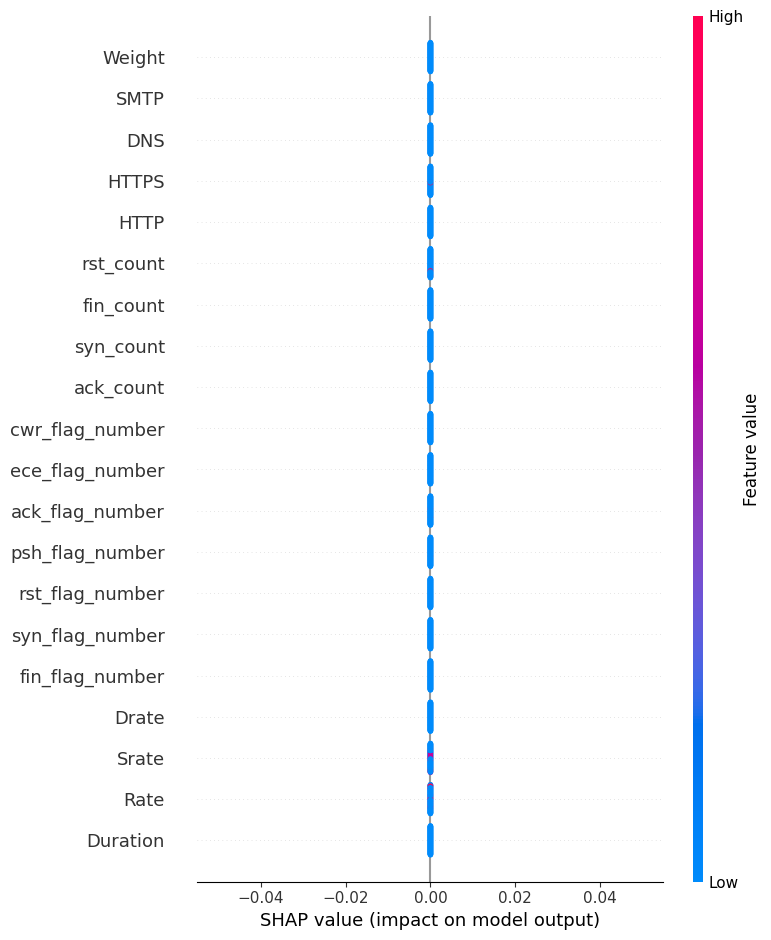

In [ ]:
#3
import shap

# Subset of test data for SHAP
subset_size = 100
subset_indices = np.random.choice(X_test.shape[0], subset_size, replace=False)
X_test_subset = X_test.iloc[subset_indices]

# Initialize SHAP KernelExplainer
explainer = shap.KernelExplainer(catboost_clf.predict, X_test_subset)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_subset)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test_subset)

In [ ]:
#4
# Predict anomalies for the subset
y_pred_subset = catboost_clf.predict(X_test_subset)

# Combine SHAP and predictions
shap_df = pd.DataFrame(shap_values, columns=[f"Feature_{i}" for i in range(X_test_subset.shape[1])])
shap_df['Prediction'] = y_pred_subset
shap_df['True_Label'] = y_test.iloc[subset_indices].values

# Save SHAP results
output_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/catboost_shap_results_ddos_tcp.csv'
shap_df.to_csv(output_path, index=False)

print("SHAP explanations and predictions saved to:", output_path)

SHAP explanations and predictions saved to: /content/drive/My Drive/IoMT/TCP&IP Attacks/catboost_shap_results_icmp1.csv


#TCP IP-DDoS-UDP1

In [ ]:

#1
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from catboost import CatBoostClassifier

# Define paths for training and test datasets
train_file_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/TCP_IP-DDoS-UDP1_train.pcap.csv'
test_file_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/TCP_IP-DDoS-UDP1_test.pcap.csv'
model_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/catboost_ddos_udp_model.cbm'

# Load datasets
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# Drop missing values
train_data = train_data.dropna()
test_data = test_data.dropna()

# Normalize the datasets
scaler = StandardScaler()
train_data_normalized = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns)
test_data_normalized = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)

# Identify columns for anomaly detection
columns_to_check = ['Rate', 'Duration', 'Header_Length', 'Srate', 'Drate']

# Calculate Z-scores
z_scores_train = np.abs(train_data_normalized[columns_to_check].apply(lambda x: (x - x.mean()) / x.std()))
z_scores_test = np.abs(test_data_normalized[columns_to_check].apply(lambda x: (x - x.mean()) / x.std()))

# Define threshold for anomalies (e.g., 3 standard deviations)
threshold = 3

# Create an 'is_anomaly' column
train_data_normalized['is_anomaly'] = (z_scores_train > threshold).any(axis=1).astype(int)
test_data_normalized['is_anomaly'] = (z_scores_test > threshold).any(axis=1).astype(int)

# Separate features (X) and labels (y)
X_train = train_data_normalized.drop('is_anomaly', axis=1)
y_train = train_data_normalized['is_anomaly']
X_test = test_data_normalized.drop('is_anomaly', axis=1)
y_test = test_data_normalized['is_anomaly']

# Initialize and train CatBoostClassifier
catboost_clf = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=10, eval_metric='Accuracy', verbose=100, random_seed=42)
catboost_clf.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# Save the trained model
catboost_clf.save_model(model_path)

# Evaluate on test data
y_pred = catboost_clf.predict(X_test)
print("Test Set Performance:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Save results
test_data_normalized['predicted_anomaly'] = y_pred
output_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/TCP_IP_DDoS_UDP1_test_with_anomalies_catboost.csv'
test_data_normalized.to_csv(output_path, index=False)

# Print anomaly summary
anomalies_count = test_data_normalized['predicted_anomaly'].sum()
print(f'Number of anomalies detected in the test data: {anomalies_count}')

0:	learn: 0.9970704	test: 0.9963045	best: 0.9963045 (0)	total: 226ms	remaining: 1m 52s
100:	learn: 0.9989232	test: 0.9965330	best: 0.9966740 (2)	total: 29.8s	remaining: 1m 57s
200:	learn: 0.9989378	test: 0.9965281	best: 0.9966740 (2)	total: 53.3s	remaining: 1m 19s
300:	learn: 0.9989378	test: 0.9965281	best: 0.9966740 (2)	total: 1m 18s	remaining: 52.2s
400:	learn: 0.9989378	test: 0.9965281	best: 0.9966740 (2)	total: 1m 43s	remaining: 25.6s
499:	learn: 0.9989378	test: 0.9965281	best: 0.9966740 (2)	total: 2m 7s	remaining: 0us

bestTest = 0.9966740253
bestIteration = 2

Shrink model to first 3 iterations.
Test Set Performance:
[[198321    506]
 [   178   6649]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    198827
           1       0.93      0.97      0.95      6827

    accuracy                           1.00    205654
   macro avg       0.96      0.99      0.97    205654
weighted avg       1.00      1.00      1.00    205654

Number 

In [ ]:
#2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import numpy as np

# Build Generator
def build_generator(input_dim, output_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dense(256, activation='relu'),
        Dense(output_dim, activation='tanh')
    ])
    return model

# Build Discriminator
def build_discriminator(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Dimensions
input_dim = X_train.shape[1]
output_dim = X_train.shape[1]

# Initialize Generator and Discriminator
generator = build_generator(input_dim, output_dim)
discriminator = build_discriminator(output_dim)
discriminator.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

# Build and Compile GAN
gan = Sequential([generator, discriminator])
gan.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy')

# Train GAN
num_epochs = 100
batch_size = 64

for epoch in range(num_epochs):
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_data = X_train.iloc[idx].values

    # Generate fake data
    noise = np.random.normal(0, 1, (batch_size, input_dim))
    fake_data = generator.predict(noise)

    # Train discriminator
    d_loss_real = discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_data, np.zeros((batch_size, 1)))

    # Train generator
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Discriminator Loss: {d_loss_real[0]}, Generator Loss: {g_loss}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch 0, Discriminator Loss: 0.6732965111732483, Generator Loss: [array(0.6827372, dtype=float32), array(0.6827372, dtype=float32), array(0.734375, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch 10, Discriminator Loss: 0.6796058416366577, Generator Loss: [array(0.6899369, dtype=float32), array(0.6899369, dtype=float32), array(0.5511364, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━

  0%|          | 0/100 [00:00<?, ?it/s]

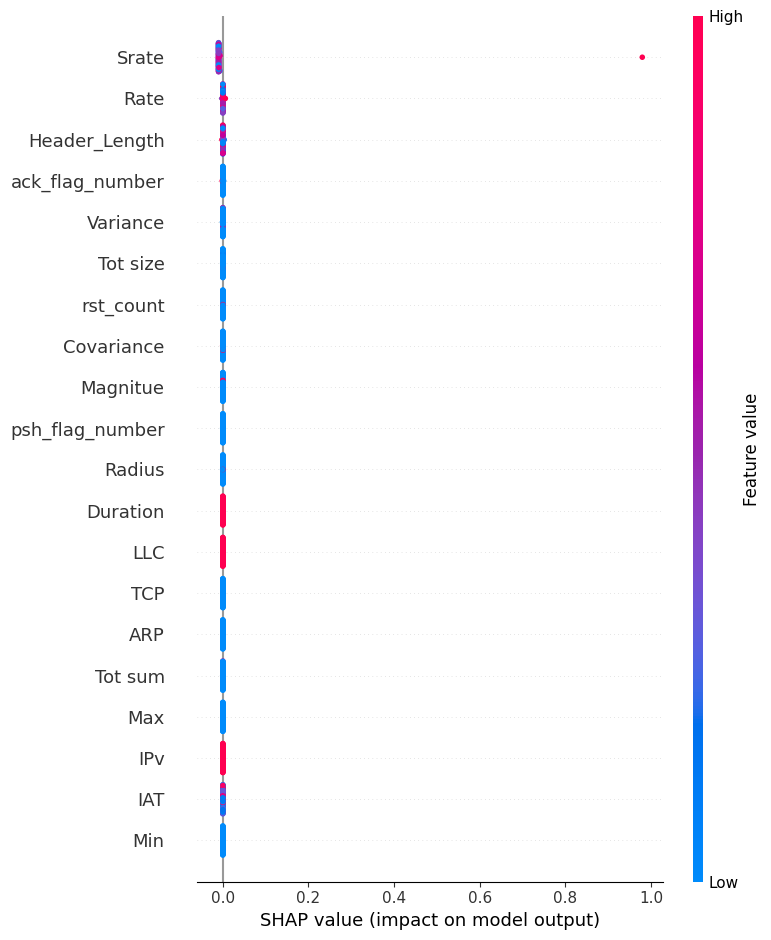

In [ ]:
#3
import shap

# Subset of test data for SHAP
subset_size = 100
subset_indices = np.random.choice(X_test.shape[0], subset_size, replace=False)
X_test_subset = X_test.iloc[subset_indices]

# Initialize SHAP KernelExplainer
explainer = shap.KernelExplainer(catboost_clf.predict, X_test_subset)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_subset)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test_subset)

In [ ]:
#4
# Predict anomalies for the subset
y_pred_subset = catboost_clf.predict(X_test_subset)

# Combine SHAP and predictions
shap_df = pd.DataFrame(shap_values, columns=[f"Feature_{i}" for i in range(X_test_subset.shape[1])])
shap_df['Prediction'] = y_pred_subset
shap_df['True_Label'] = y_test.iloc[subset_indices].values

# Save SHAP results
output_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/catboost_shap_results_ddos_udp1.csv'
shap_df.to_csv(output_path, index=False)

print("SHAP explanations and predictions saved to:", output_path)

SHAP explanations and predictions saved to: /content/drive/My Drive/IoMT/TCP&IP Attacks/catboost_shap_results_icmp1.csv


#TCP IP-DDoS-UDP2

In [ ]:

#1
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from catboost import CatBoostClassifier

# Define paths for training and test datasets
train_file_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/TCP_IP-DDoS-UDP2_train.pcap.csv'
test_file_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/TCP_IP-DDoS-UDP2_test.pcap.csv'
model_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/catboost_ddos_udp2_model.cbm'

# Load datasets
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# Drop missing values
train_data = train_data.dropna()
test_data = test_data.dropna()

# Normalize the datasets
scaler = StandardScaler()
train_data_normalized = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns)
test_data_normalized = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)

# Identify columns for anomaly detection
columns_to_check = ['Rate', 'Duration', 'Header_Length', 'Srate', 'Drate']

# Calculate Z-scores
z_scores_train = np.abs(train_data_normalized[columns_to_check].apply(lambda x: (x - x.mean()) / x.std()))
z_scores_test = np.abs(test_data_normalized[columns_to_check].apply(lambda x: (x - x.mean()) / x.std()))

# Define threshold for anomalies (e.g., 3 standard deviations)
threshold = 3

# Create an 'is_anomaly' column
train_data_normalized['is_anomaly'] = (z_scores_train > threshold).any(axis=1).astype(int)
test_data_normalized['is_anomaly'] = (z_scores_test > threshold).any(axis=1).astype(int)

# Separate features (X) and labels (y)
X_train = train_data_normalized.drop('is_anomaly', axis=1)
y_train = train_data_normalized['is_anomaly']
X_test = test_data_normalized.drop('is_anomaly', axis=1)
y_test = test_data_normalized['is_anomaly']

# Initialize and train CatBoostClassifier
catboost_clf = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=10, eval_metric='Accuracy', verbose=100, random_seed=42)
catboost_clf.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# Save the trained model
catboost_clf.save_model(model_path)

# Evaluate on test data
y_pred = catboost_clf.predict(X_test)
print("Test Set Performance:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Save results
test_data_normalized['predicted_anomaly'] = y_pred
output_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/TCP_IP_DDoS_UDP2_test_with_anomalies_catboost.csv'
test_data_normalized.to_csv(output_path, index=False)

# Print anomaly summary
anomalies_count = test_data_normalized['predicted_anomaly'].sum()
print(f'Number of anomalies detected in the test data: {anomalies_count}')

0:	learn: 0.9987361	test: 0.9909536	best: 0.9909536 (0)	total: 224ms	remaining: 1m 51s
100:	learn: 0.9991751	test: 0.9926350	best: 0.9961193 (4)	total: 23.2s	remaining: 1m 31s
200:	learn: 0.9992571	test: 0.9924496	best: 0.9961193 (4)	total: 48.1s	remaining: 1m 11s
300:	learn: 0.9992571	test: 0.9924496	best: 0.9961193 (4)	total: 1m 11s	remaining: 47.2s
400:	learn: 0.9992571	test: 0.9924496	best: 0.9961193 (4)	total: 1m 35s	remaining: 23.6s
499:	learn: 0.9992571	test: 0.9924496	best: 0.9961193 (4)	total: 1m 57s	remaining: 0us

bestTest = 0.9961193228
bestIteration = 4

Shrink model to first 5 iterations.
Test Set Performance:
[[150350    409]
 [   198   5459]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    150759
           1       0.93      0.96      0.95      5657

    accuracy                           1.00    156416
   macro avg       0.96      0.98      0.97    156416
weighted avg       1.00      1.00      1.00    156416

Number

In [ ]:
#2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import numpy as np

# Build Generator
def build_generator(input_dim, output_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dense(256, activation='relu'),
        Dense(output_dim, activation='tanh')
    ])
    return model

# Build Discriminator
def build_discriminator(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Dimensions
input_dim = X_train.shape[1]
output_dim = X_train.shape[1]

# Initialize Generator and Discriminator
generator = build_generator(input_dim, output_dim)
discriminator = build_discriminator(output_dim)
discriminator.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

# Build and Compile GAN
gan = Sequential([generator, discriminator])
gan.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy')

# Train GAN
num_epochs = 100
batch_size = 64

for epoch in range(num_epochs):
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_data = X_train.iloc[idx].values

    # Generate fake data
    noise = np.random.normal(0, 1, (batch_size, input_dim))
    fake_data = generator.predict(noise)

    # Train discriminator
    d_loss_real = discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_data, np.zeros((batch_size, 1)))

    # Train generator
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Discriminator Loss: {d_loss_real[0]}, Generator Loss: {g_loss}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 0, Discriminator Loss: 0.6328310966491699, Generator Loss: [array(0.7092091, dtype=float32), array(0.7092091, dtype=float32), array(0.375, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 10, Discriminator Loss: 0.7234896421432495, Generator Loss: [array(0.7343077, dtype=float32), array(0.7343077, dtype=float32), array(0.48863637, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:2299: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:2300: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:2299: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:2300: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:2299: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_

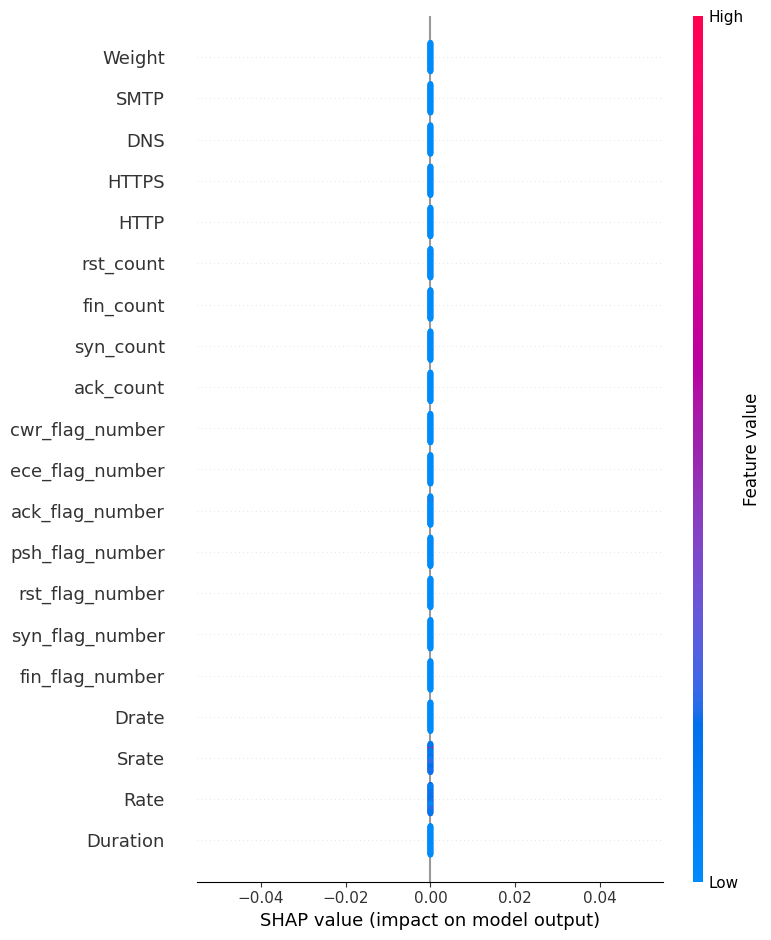

In [ ]:
#3
import shap

# Subset of test data for SHAP
subset_size = 100
subset_indices = np.random.choice(X_test.shape[0], subset_size, replace=False)
X_test_subset = X_test.iloc[subset_indices]

# Initialize SHAP KernelExplainer
explainer = shap.KernelExplainer(catboost_clf.predict, X_test_subset)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_subset)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test_subset)

In [ ]:
#4
# Predict anomalies for the subset
y_pred_subset = catboost_clf.predict(X_test_subset)

# Combine SHAP and predictions
shap_df = pd.DataFrame(shap_values, columns=[f"Feature_{i}" for i in range(X_test_subset.shape[1])])
shap_df['Prediction'] = y_pred_subset
shap_df['True_Label'] = y_test.iloc[subset_indices].values

# Save SHAP results
output_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/catboost_shap_results_ddos_udp2.csv'
shap_df.to_csv(output_path, index=False)

print("SHAP explanations and predictions saved to:", output_path)

SHAP explanations and predictions saved to: /content/drive/My Drive/IoMT/TCP&IP Attacks/catboost_shap_results_icmp1.csv


#TCP IP-DoS-ICMP

In [ ]:

#1
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from catboost import CatBoostClassifier

# Define paths for training and test datasets
train_file_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/TCP_IP-DoS-ICMP1_train.pcap.csv'
test_file_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/TCP_IP-DoS-ICMP_test.pcap.csv'
model_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/catboost_dos_icmp_model.cbm'

# Load datasets
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# Drop missing values
train_data = train_data.dropna()
test_data = test_data.dropna()

# Normalize the datasets
scaler = StandardScaler()
train_data_normalized = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns)
test_data_normalized = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)

# Identify columns for anomaly detection
columns_to_check = ['Rate', 'Duration', 'Header_Length', 'Srate', 'Drate']

# Calculate Z-scores
z_scores_train = np.abs(train_data_normalized[columns_to_check].apply(lambda x: (x - x.mean()) / x.std()))
z_scores_test = np.abs(test_data_normalized[columns_to_check].apply(lambda x: (x - x.mean()) / x.std()))

# Define threshold for anomalies (e.g., 3 standard deviations)
threshold = 3

# Create an 'is_anomaly' column
train_data_normalized['is_anomaly'] = (z_scores_train > threshold).any(axis=1).astype(int)
test_data_normalized['is_anomaly'] = (z_scores_test > threshold).any(axis=1).astype(int)

# Separate features (X) and labels (y)
X_train = train_data_normalized.drop('is_anomaly', axis=1)
y_train = train_data_normalized['is_anomaly']
X_test = test_data_normalized.drop('is_anomaly', axis=1)
y_test = test_data_normalized['is_anomaly']

# Initialize and train CatBoostClassifier
catboost_clf = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=10, eval_metric='Accuracy', verbose=100, random_seed=42)
catboost_clf.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# Save the trained model
catboost_clf.save_model(model_path)

# Evaluate on test data
y_pred = catboost_clf.predict(X_test)
print("Test Set Performance:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Save results
test_data_normalized['predicted_anomaly'] = y_pred
output_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/TCP_IP_DoS_ICMP_test_with_anomalies_catboost.csv'
test_data_normalized.to_csv(output_path, index=False)

# Print anomaly summary
anomalies_count = test_data_normalized['predicted_anomaly'].sum()
print(f'Number of anomalies detected in the test data: {anomalies_count}')

0:	learn: 0.9918857	test: 0.9418787	best: 0.9418787 (0)	total: 57.9ms	remaining: 28.9s
100:	learn: 0.9997608	test: 0.8847021	best: 0.9440020 (2)	total: 15.9s	remaining: 1m 2s
200:	learn: 0.9998660	test: 0.8846717	best: 0.9440020 (2)	total: 32.2s	remaining: 47.8s
300:	learn: 0.9999139	test: 0.8846818	best: 0.9440020 (2)	total: 47.4s	remaining: 31.3s
400:	learn: 0.9999426	test: 0.8846717	best: 0.9440020 (2)	total: 1m 3s	remaining: 15.6s
499:	learn: 0.9999426	test: 0.8846717	best: 0.9440020 (2)	total: 1m 19s	remaining: 0us

bestTest = 0.9440019506
bestIteration = 2

Shrink model to first 3 iterations.
Test Set Performance:
[[92196  2255]
 [ 3257   724]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     94451
           1       0.24      0.18      0.21      3981

    accuracy                           0.94     98432
   macro avg       0.60      0.58      0.59     98432
weighted avg       0.94      0.94      0.94     98432

Number of anom

In [ ]:
#2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import numpy as np

# Build Generator
def build_generator(input_dim, output_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dense(256, activation='relu'),
        Dense(output_dim, activation='tanh')
    ])
    return model

# Build Discriminator
def build_discriminator(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Dimensions
input_dim = X_train.shape[1]
output_dim = X_train.shape[1]

# Initialize Generator and Discriminator
generator = build_generator(input_dim, output_dim)
discriminator = build_discriminator(output_dim)
discriminator.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

# Build and Compile GAN
gan = Sequential([generator, discriminator])
gan.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy')

# Train GAN
num_epochs = 100
batch_size = 64

for epoch in range(num_epochs):
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_data = X_train.iloc[idx].values

    # Generate fake data
    noise = np.random.normal(0, 1, (batch_size, input_dim))
    fake_data = generator.predict(noise)

    # Train discriminator
    d_loss_real = discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_data, np.zeros((batch_size, 1)))

    # Train generator
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Discriminator Loss: {d_loss_real[0]}, Generator Loss: {g_loss}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step  
Epoch 0, Discriminator Loss: 0.6118963956832886, Generator Loss: [array(0.77022815, dtype=float32), array(0.77022815, dtype=float32), array(0.5, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch 10, Discriminator Loss: 0.7686889171600342, Generator Loss: [array(0.7830393, dtype=float32), array(0.7830393, dtype=float32), array(0.5, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/

  0%|          | 0/100 [00:00<?, ?it/s]

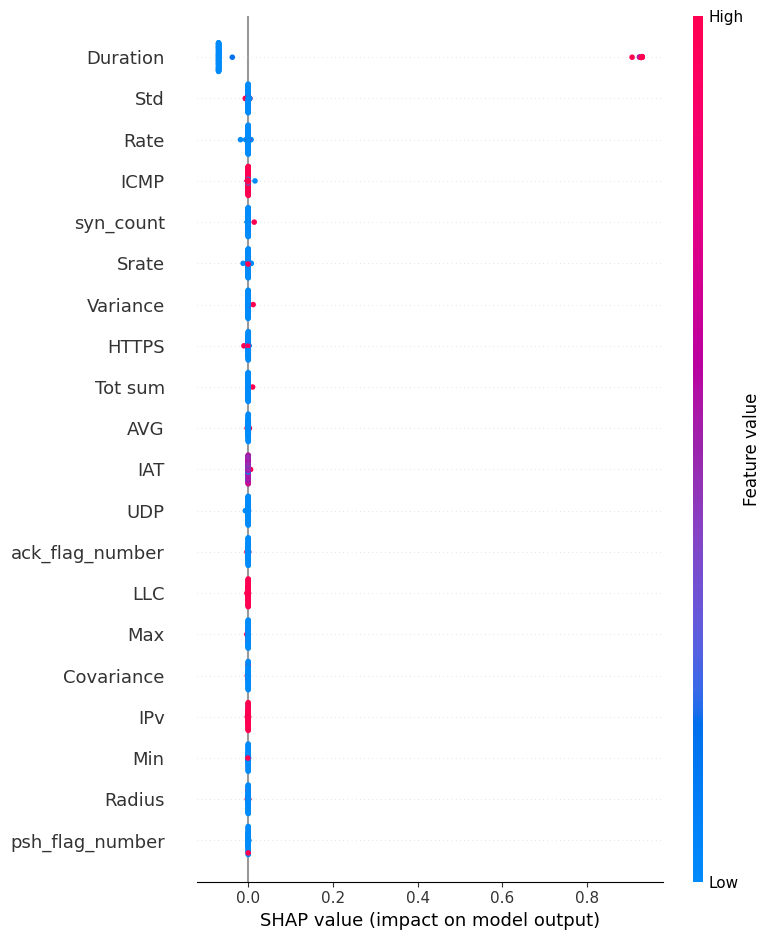

In [ ]:
#3
import shap

# Subset of test data for SHAP
subset_size = 100
subset_indices = np.random.choice(X_test.shape[0], subset_size, replace=False)
X_test_subset = X_test.iloc[subset_indices]

# Initialize SHAP KernelExplainer
explainer = shap.KernelExplainer(catboost_clf.predict, X_test_subset)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_subset)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test_subset)

In [ ]:
#4
# Predict anomalies for the subset
y_pred_subset = catboost_clf.predict(X_test_subset)

# Combine SHAP and predictions
shap_df = pd.DataFrame(shap_values, columns=[f"Feature_{i}" for i in range(X_test_subset.shape[1])])
shap_df['Prediction'] = y_pred_subset
shap_df['True_Label'] = y_test.iloc[subset_indices].values

# Save SHAP results
output_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/catboost_shap_results_dos_icmp.csv'
shap_df.to_csv(output_path, index=False)

print("SHAP explanations and predictions saved to:", output_path)

SHAP explanations and predictions saved to: /content/drive/My Drive/IoMT/TCP&IP Attacks/catboost_shap_results_icmp1.csv


#TCP IP-DoS-TCP

In [ ]:

#1
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from catboost import CatBoostClassifier

# Define paths for training and test datasets
train_file_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/TCP_IP-DoS-TCP1_train.pcap.csv'
test_file_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/TCP_IP-DoS-TCP_test.pcap.csv'
model_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/catboost_dos_tcp_model.cbm'

# Load datasets
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# Drop missing values
train_data = train_data.dropna()
test_data = test_data.dropna()

# Normalize the datasets
scaler = StandardScaler()
train_data_normalized = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns)
test_data_normalized = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)

# Identify columns for anomaly detection
columns_to_check = ['Rate', 'Duration', 'Header_Length', 'Srate', 'Drate']

# Calculate Z-scores
z_scores_train = np.abs(train_data_normalized[columns_to_check].apply(lambda x: (x - x.mean()) / x.std()))
z_scores_test = np.abs(test_data_normalized[columns_to_check].apply(lambda x: (x - x.mean()) / x.std()))

# Define threshold for anomalies (e.g., 3 standard deviations)
threshold = 3

# Create an 'is_anomaly' column
train_data_normalized['is_anomaly'] = (z_scores_train > threshold).any(axis=1).astype(int)
test_data_normalized['is_anomaly'] = (z_scores_test > threshold).any(axis=1).astype(int)

# Separate features (X) and labels (y)
X_train = train_data_normalized.drop('is_anomaly', axis=1)
y_train = train_data_normalized['is_anomaly']
X_test = test_data_normalized.drop('is_anomaly', axis=1)
y_test = test_data_normalized['is_anomaly']

# Initialize and train CatBoostClassifier
catboost_clf = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=10, eval_metric='Accuracy', verbose=100, random_seed=42)
catboost_clf.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# Save the trained model
catboost_clf.save_model(model_path)

# Evaluate on test data
y_pred = catboost_clf.predict(X_test)
print("Test Set Performance:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Save results
test_data_normalized['predicted_anomaly'] = y_pred
output_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/TCP_IP_DoS_TCP_test_with_anomalies_catboost.csv'
test_data_normalized.to_csv(output_path, index=False)

# Print anomaly summary
anomalies_count = test_data_normalized['predicted_anomaly'].sum()
print(f'Number of anomalies detected in the test data: {anomalies_count}')

0:	learn: 0.9963105	test: 0.9102758	best: 0.9102758 (0)	total: 281ms	remaining: 2m 20s
100:	learn: 1.0000000	test: 0.9057445	best: 0.9150263 (1)	total: 15.9s	remaining: 1m 2s
200:	learn: 1.0000000	test: 0.9057445	best: 0.9150263 (1)	total: 31.4s	remaining: 46.7s
300:	learn: 1.0000000	test: 0.9057445	best: 0.9150263 (1)	total: 46.4s	remaining: 30.7s
400:	learn: 1.0000000	test: 0.9057445	best: 0.9150263 (1)	total: 1m 1s	remaining: 15.2s
499:	learn: 1.0000000	test: 0.9057445	best: 0.9150263 (1)	total: 1m 15s	remaining: 0us

bestTest = 0.9150263107
bestIteration = 1

Shrink model to first 2 iterations.
Test Set Performance:
[[71981  6818]
 [  158  3139]]
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     78799
           1       0.32      0.95      0.47      3297

    accuracy                           0.92     82096
   macro avg       0.66      0.93      0.71     82096
weighted avg       0.97      0.92      0.93     82096

Number of anom

In [ ]:
#2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import numpy as np

# Build Generator
def build_generator(input_dim, output_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dense(256, activation='relu'),
        Dense(output_dim, activation='tanh')
    ])
    return model

# Build Discriminator
def build_discriminator(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Dimensions
input_dim = X_train.shape[1]
output_dim = X_train.shape[1]

# Initialize Generator and Discriminator
generator = build_generator(input_dim, output_dim)
discriminator = build_discriminator(output_dim)
discriminator.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

# Build and Compile GAN
gan = Sequential([generator, discriminator])
gan.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy')

# Train GAN
num_epochs = 100
batch_size = 64

for epoch in range(num_epochs):
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_data = X_train.iloc[idx].values

    # Generate fake data
    noise = np.random.normal(0, 1, (batch_size, input_dim))
    fake_data = generator.predict(noise)

    # Train discriminator
    d_loss_real = discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_data, np.zeros((batch_size, 1)))

    # Train generator
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Discriminator Loss: {d_loss_real[0]}, Generator Loss: {g_loss}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch 0, Discriminator Loss: 0.6706728935241699, Generator Loss: [array(0.7226913, dtype=float32), array(0.7226913, dtype=float32), array(0.5078125, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 10, Discriminator Loss: 0.72132807970047, Generator Loss: [array(0.73076266, dtype=float32), array(0.73076266, dtype=float32), array(0.50071025, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━

  0%|          | 0/100 [00:00<?, ?it/s]

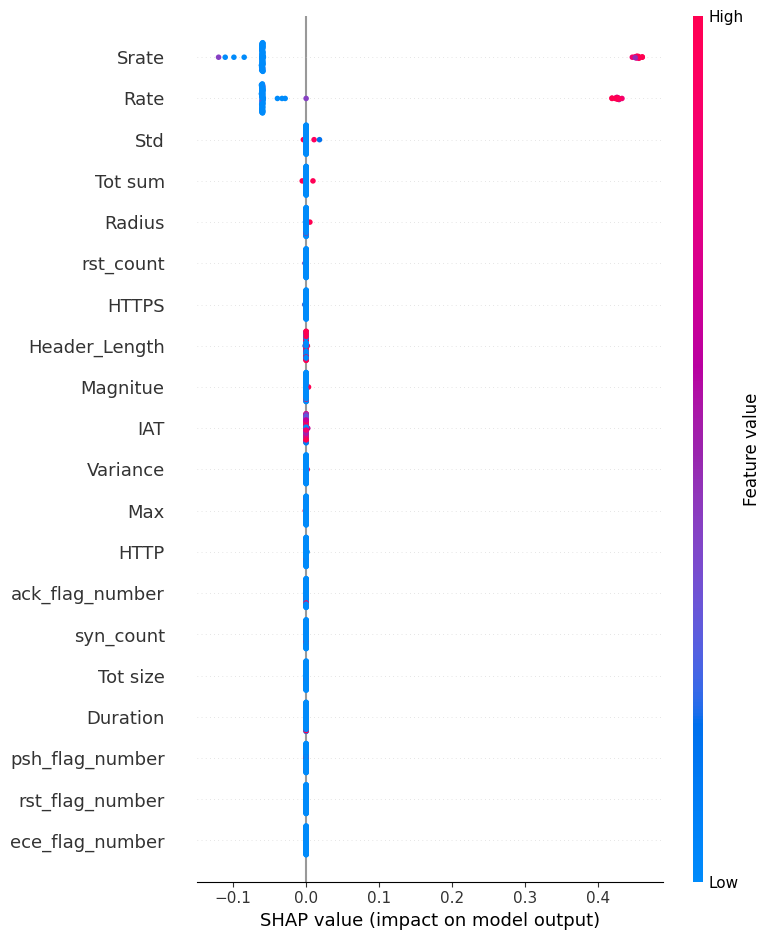

In [ ]:
#3
import shap

# Subset of test data for SHAP
subset_size = 100
subset_indices = np.random.choice(X_test.shape[0], subset_size, replace=False)
X_test_subset = X_test.iloc[subset_indices]

# Initialize SHAP KernelExplainer
explainer = shap.KernelExplainer(catboost_clf.predict, X_test_subset)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_subset)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test_subset)

In [ ]:
#4
# Predict anomalies for the subset
y_pred_subset = catboost_clf.predict(X_test_subset)

# Combine SHAP and predictions
shap_df = pd.DataFrame(shap_values, columns=[f"Feature_{i}" for i in range(X_test_subset.shape[1])])
shap_df['Prediction'] = y_pred_subset
shap_df['True_Label'] = y_test.iloc[subset_indices].values

# Save SHAP results
output_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/catboost_shap_results_dos_tcp.csv'
shap_df.to_csv(output_path, index=False)

print("SHAP explanations and predictions saved to:", output_path)

SHAP explanations and predictions saved to: /content/drive/My Drive/IoMT/TCP&IP Attacks/catboost_shap_results_dos_tcp.csv


#TCP IP-DoS-UDP

In [ ]:

#1
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from catboost import CatBoostClassifier

# Define paths for training and test datasets
train_file_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/TCP_IP-DoS-UDP1_train.pcap.csv'
test_file_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/TCP_IP-DoS-UDP_test.pcap.csv'
model_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/catboost_dos_udp_model.cbm'

# Load datasets
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# Drop missing values
train_data = train_data.dropna()
test_data = test_data.dropna()

# Normalize the datasets
scaler = StandardScaler()
train_data_normalized = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns)
test_data_normalized = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)

# Identify columns for anomaly detection
columns_to_check = ['Rate', 'Duration', 'Header_Length', 'Srate', 'Drate']

# Calculate Z-scores
z_scores_train = np.abs(train_data_normalized[columns_to_check].apply(lambda x: (x - x.mean()) / x.std()))
z_scores_test = np.abs(test_data_normalized[columns_to_check].apply(lambda x: (x - x.mean()) / x.std()))

# Define threshold for anomalies (e.g., 3 standard deviations)
threshold = 3

# Create an 'is_anomaly' column
train_data_normalized['is_anomaly'] = (z_scores_train > threshold).any(axis=1).astype(int)
test_data_normalized['is_anomaly'] = (z_scores_test > threshold).any(axis=1).astype(int)

# Separate features (X) and labels (y)
X_train = train_data_normalized.drop('is_anomaly', axis=1)
y_train = train_data_normalized['is_anomaly']
X_test = test_data_normalized.drop('is_anomaly', axis=1)
y_test = test_data_normalized['is_anomaly']

# Initialize and train CatBoostClassifier
catboost_clf = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=10, eval_metric='Accuracy', verbose=100, random_seed=42)
catboost_clf.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# Save the trained model
catboost_clf.save_model(model_path)

# Evaluate on test data
y_pred = catboost_clf.predict(X_test)
print("Test Set Performance:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Save results
test_data_normalized['predicted_anomaly'] = y_pred
output_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/TCP_IP_DoS_UDP_test_with_anomalies_catboost.csv'
test_data_normalized.to_csv(output_path, index=False)

# Print anomaly summary
anomalies_count = test_data_normalized['predicted_anomaly'].sum()
print(f'Number of anomalies detected in the test data: {anomalies_count}')

0:	learn: 0.9972192	test: 0.9982261	best: 0.9982261 (0)	total: 368ms	remaining: 3m 3s
100:	learn: 0.9994380	test: 0.9982625	best: 0.9982698 (1)	total: 22.8s	remaining: 1m 30s
200:	learn: 0.9994891	test: 0.9982625	best: 0.9982698 (1)	total: 43s	remaining: 1m 3s
300:	learn: 0.9994891	test: 0.9982625	best: 0.9982698 (1)	total: 1m 3s	remaining: 41.9s
400:	learn: 0.9994891	test: 0.9982625	best: 0.9982698 (1)	total: 1m 24s	remaining: 20.8s
499:	learn: 0.9994891	test: 0.9982625	best: 0.9982698 (1)	total: 1m 43s	remaining: 0us

bestTest = 0.9982697578
bestIteration = 1

Shrink model to first 2 iterations.
Test Set Performance:
[[133191     40]
 [   198   4124]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    133231
           1       0.99      0.95      0.97      4322

    accuracy                           1.00    137553
   macro avg       0.99      0.98      0.99    137553
weighted avg       1.00      1.00      1.00    137553

Number of a

In [ ]:
#2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import numpy as np

# Build Generator
def build_generator(input_dim, output_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dense(256, activation='relu'),
        Dense(output_dim, activation='tanh')
    ])
    return model

# Build Discriminator
def build_discriminator(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Dimensions
input_dim = X_train.shape[1]
output_dim = X_train.shape[1]

# Initialize Generator and Discriminator
generator = build_generator(input_dim, output_dim)
discriminator = build_discriminator(output_dim)
discriminator.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

# Build and Compile GAN
gan = Sequential([generator, discriminator])
gan.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy')

# Train GAN
num_epochs = 100
batch_size = 64

for epoch in range(num_epochs):
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_data = X_train.iloc[idx].values

    # Generate fake data
    noise = np.random.normal(0, 1, (batch_size, input_dim))
    fake_data = generator.predict(noise)

    # Train discriminator
    d_loss_real = discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_data, np.zeros((batch_size, 1)))

    # Train generator
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Discriminator Loss: {d_loss_real[0]}, Generator Loss: {g_loss}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 0, Discriminator Loss: 0.6920919418334961, Generator Loss: [array(0.6914636, dtype=float32), array(0.6914636, dtype=float32), array(0.671875, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 10, Discriminator Loss: 0.7059506773948669, Generator Loss: [array(0.71701527, dtype=float32), array(0.71701527, dtype=float32), array(0.5269886, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━

  0%|          | 0/100 [00:00<?, ?it/s]

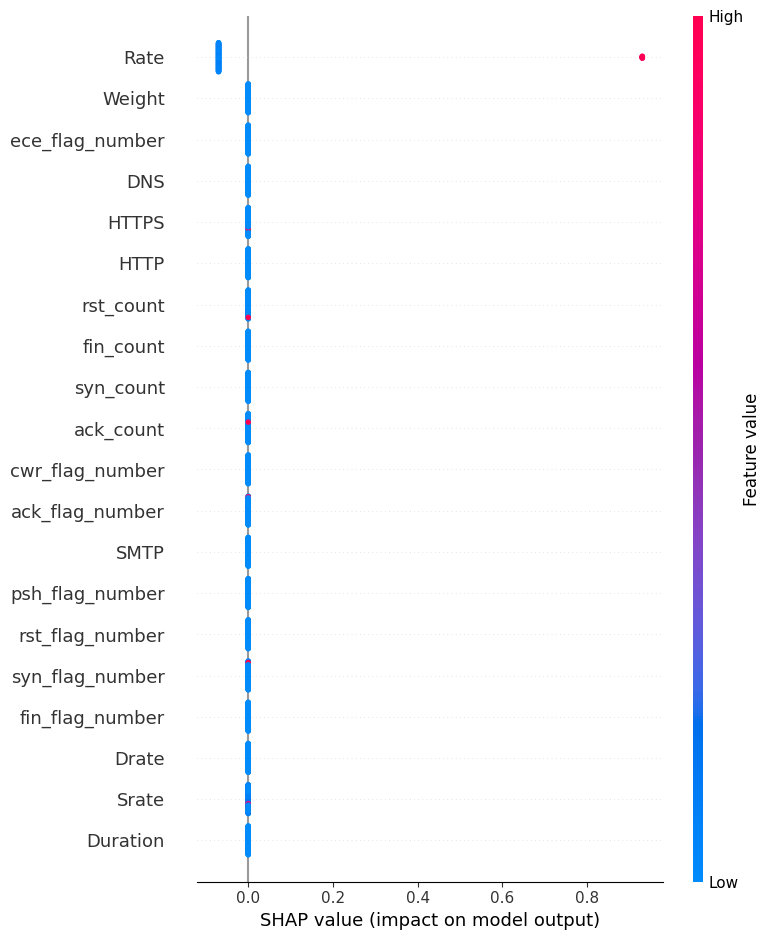

In [ ]:
#3
import shap

# Subset of test data for SHAP
subset_size = 100
subset_indices = np.random.choice(X_test.shape[0], subset_size, replace=False)
X_test_subset = X_test.iloc[subset_indices]

# Initialize SHAP KernelExplainer
explainer = shap.KernelExplainer(catboost_clf.predict, X_test_subset)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_subset)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test_subset)

In [ ]:
#4
# Predict anomalies for the subset
y_pred_subset = catboost_clf.predict(X_test_subset)

# Combine SHAP and predictions
shap_df = pd.DataFrame(shap_values, columns=[f"Feature_{i}" for i in range(X_test_subset.shape[1])])
shap_df['Prediction'] = y_pred_subset
shap_df['True_Label'] = y_test.iloc[subset_indices].values

# Save SHAP results
output_path = '/content/drive/My Drive/IoMT/TCP&IP Attacks/catboost_shap_results_dos_udp.csv'
shap_df.to_csv(output_path, index=False)

print("SHAP explanations and predictions saved to:", output_path)

SHAP explanations and predictions saved to: /content/drive/My Drive/IoMT/TCP&IP Attacks/catboost_shap_results_dos_udp.csv


#ARP SPOOFING

In [ ]:

#1
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from catboost import CatBoostClassifier

# Define paths for training and test datasets
train_file_path = '/content/drive/My Drive/IoMT/ARP Spoofing/ARP_Spoofing_train.pcap.csv'
test_file_path = '/content/drive/My Drive/IoMT/ARP Spoofing/ARP_Spoofing_test.pcap.csv'
model_path = '/content/drive/My Drive/IoMT/ARP Spoofing/catboost_arp_spoofing_model.cbm'

# Load datasets
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# Drop missing values
train_data = train_data.dropna()
test_data = test_data.dropna()

# Normalize the datasets
scaler = StandardScaler()
train_data_normalized = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns)
test_data_normalized = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)

# Identify columns for anomaly detection
columns_to_check = ['Rate', 'Duration', 'Header_Length', 'Srate', 'Drate']

# Calculate Z-scores
z_scores_train = np.abs(train_data_normalized[columns_to_check].apply(lambda x: (x - x.mean()) / x.std()))
z_scores_test = np.abs(test_data_normalized[columns_to_check].apply(lambda x: (x - x.mean()) / x.std()))

# Define threshold for anomalies (e.g., 3 standard deviations)
threshold = 3

# Create an 'is_anomaly' column
train_data_normalized['is_anomaly'] = (z_scores_train > threshold).any(axis=1).astype(int)
test_data_normalized['is_anomaly'] = (z_scores_test > threshold).any(axis=1).astype(int)

# Separate features (X) and labels (y)
X_train = train_data_normalized.drop('is_anomaly', axis=1)
y_train = train_data_normalized['is_anomaly']
X_test = test_data_normalized.drop('is_anomaly', axis=1)
y_test = test_data_normalized['is_anomaly']

# Initialize and train CatBoostClassifier
catboost_clf = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=10, eval_metric='Accuracy', verbose=100, random_seed=42)
catboost_clf.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# Save the trained model
catboost_clf.save_model(model_path)

# Evaluate on test data
y_pred = catboost_clf.predict(X_test)
print("Test Set Performance:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Save results
test_data_normalized['predicted_anomaly'] = y_pred
output_path = '/content/drive/My Drive/IoMT/ARP Spoofing/ARP_Spoofing_with_anomalies_catboost.csv'
test_data_normalized.to_csv(output_path, index=False)

# Print anomaly summary
anomalies_count = test_data_normalized['predicted_anomaly'].sum()
print(f'Number of anomalies detected in the test data: {anomalies_count}')

0:	learn: 0.9949523	test: 0.9655963	best: 0.9655963 (0)	total: 242ms	remaining: 2m
100:	learn: 1.0000000	test: 0.9684633	best: 0.9690367 (3)	total: 20.9s	remaining: 1m 22s
200:	learn: 1.0000000	test: 0.9684633	best: 0.9690367 (3)	total: 30.8s	remaining: 45.8s
300:	learn: 1.0000000	test: 0.9684633	best: 0.9690367 (3)	total: 38s	remaining: 25.1s
400:	learn: 1.0000000	test: 0.9684633	best: 0.9690367 (3)	total: 42.9s	remaining: 10.6s
499:	learn: 1.0000000	test: 0.9684633	best: 0.9690367 (3)	total: 47.7s	remaining: 0us

bestTest = 0.9690366972
bestIteration = 3

Shrink model to first 4 iterations.
Test Set Performance:
[[1678    1]
 [  53   12]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1679
           1       0.92      0.18      0.31        65

    accuracy                           0.97      1744
   macro avg       0.95      0.59      0.65      1744
weighted avg       0.97      0.97      0.96      1744

Number of anomalies dete

In [ ]:
#2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import numpy as np

# Build Generator
def build_generator(input_dim, output_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dense(256, activation='relu'),
        Dense(output_dim, activation='tanh')
    ])
    return model

# Build Discriminator
def build_discriminator(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Dimensions
input_dim = X_train.shape[1]
output_dim = X_train.shape[1]

# Initialize Generator and Discriminator
generator = build_generator(input_dim, output_dim)
discriminator = build_discriminator(output_dim)
discriminator.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

# Build and Compile GAN
gan = Sequential([generator, discriminator])
gan.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy')

# Train GAN
num_epochs = 100
batch_size = 64

for epoch in range(num_epochs):
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_data = X_train.iloc[idx].values

    # Generate fake data
    noise = np.random.normal(0, 1, (batch_size, input_dim))
    fake_data = generator.predict(noise)

    # Train discriminator
    d_loss_real = discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_data, np.zeros((batch_size, 1)))

    # Train generator
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Discriminator Loss: {d_loss_real[0]}, Generator Loss: {g_loss}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
Epoch 0, Discriminator Loss: 0.6407029628753662, Generator Loss: [array(0.6712002, dtype=float32), array(0.6712002, dtype=float32), array(0.59375, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch 10, Discriminator Loss: 0.6474450826644897, Generator Loss: [array(0.6680084, dtype=float32), array(0.6680084, dtype=float32), array(0.51633525, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 20, Discriminator Loss: 0.6798433065414429, Generator Loss: [array(0.69509095, dtype=float32), array(0.69

  0%|          | 0/100 [00:00<?, ?it/s]

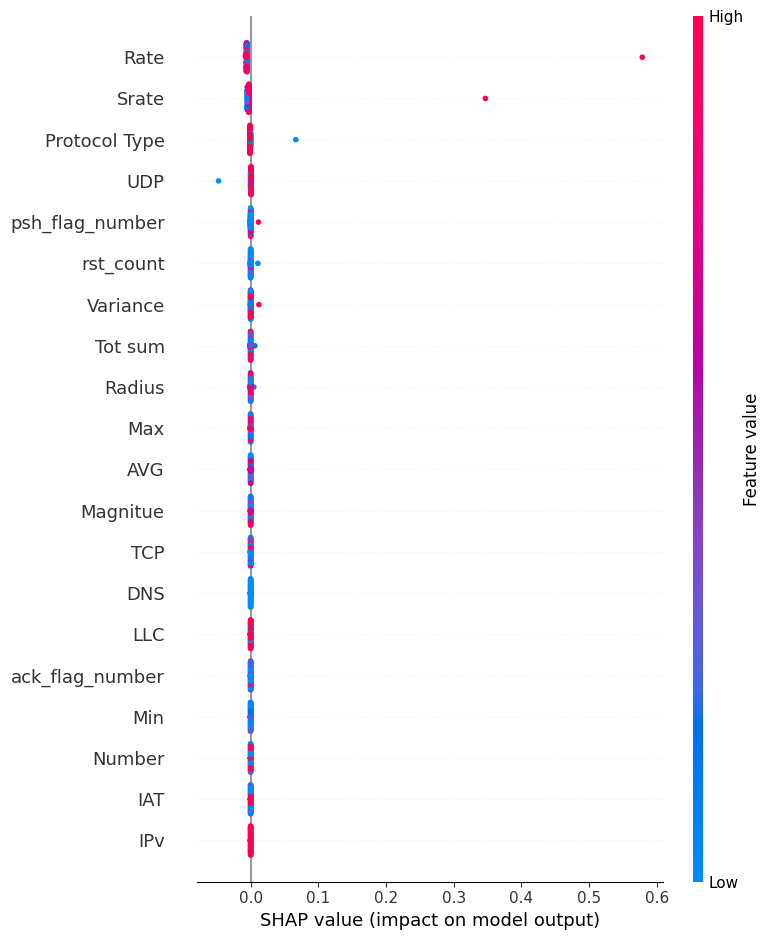

In [ ]:
#3
import shap

# Subset of test data for SHAP
subset_size = 100
subset_indices = np.random.choice(X_test.shape[0], subset_size, replace=False)
X_test_subset = X_test.iloc[subset_indices]

# Initialize SHAP KernelExplainer
explainer = shap.KernelExplainer(catboost_clf.predict, X_test_subset)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_subset)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test_subset)

In [ ]:
#4
# Predict anomalies for the subset
y_pred_subset = catboost_clf.predict(X_test_subset)

# Combine SHAP and predictions
shap_df = pd.DataFrame(shap_values, columns=[f"Feature_{i}" for i in range(X_test_subset.shape[1])])
shap_df['Prediction'] = y_pred_subset
shap_df['True_Label'] = y_test.iloc[subset_indices].values

# Save SHAP results
output_path = '/content/drive/My Drive/IoMT/ARP Spoofing/catboost_shap_results_arp_spoofing.csv'
shap_df.to_csv(output_path, index=False)

print("SHAP explanations and predictions saved to:", output_path)

SHAP explanations and predictions saved to: /content/drive/My Drive/IoMT/ARP Spoofing/catboost_shap_results_arp_spoofing.csv


#BENIGN

In [ ]:

#1
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from catboost import CatBoostClassifier

# Define paths for training and test datasets
train_file_path = '/content/drive/My Drive/IoMT/Benign/Benign_train.pcap.csv'
test_file_path = '/content/drive/My Drive/IoMT/Benign/Benign_test.pcap.csv'
model_path = '/content/drive/My Drive/IoMT/Benign/catboost_benign_model.cbm'

# Load datasets
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# Drop missing values
train_data = train_data.dropna()
test_data = test_data.dropna()

# Normalize the datasets
scaler = StandardScaler()
train_data_normalized = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns)
test_data_normalized = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)

# Identify columns for anomaly detection
columns_to_check = ['Rate', 'Duration', 'Header_Length', 'Srate', 'Drate']

# Calculate Z-scores
z_scores_train = np.abs(train_data_normalized[columns_to_check].apply(lambda x: (x - x.mean()) / x.std()))
z_scores_test = np.abs(test_data_normalized[columns_to_check].apply(lambda x: (x - x.mean()) / x.std()))

# Define threshold for anomalies (e.g., 3 standard deviations)
threshold = 3

# Create an 'is_anomaly' column
train_data_normalized['is_anomaly'] = (z_scores_train > threshold).any(axis=1).astype(int)
test_data_normalized['is_anomaly'] = (z_scores_test > threshold).any(axis=1).astype(int)

# Separate features (X) and labels (y)
X_train = train_data_normalized.drop('is_anomaly', axis=1)
y_train = train_data_normalized['is_anomaly']
X_test = test_data_normalized.drop('is_anomaly', axis=1)
y_test = test_data_normalized['is_anomaly']

# Initialize and train CatBoostClassifier
catboost_clf = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=10, eval_metric='Accuracy', verbose=100, random_seed=42)
catboost_clf.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# Save the trained model
catboost_clf.save_model(model_path)

# Evaluate on test data
y_pred = catboost_clf.predict(X_test)
print("Test Set Performance:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Save results
test_data_normalized['predicted_anomaly'] = y_pred
output_path = '/content/drive/My Drive/IoMT/Benign/Benign_with_anomalies_catboost.csv'
test_data_normalized.to_csv(output_path, index=False)

# Print anomaly summary
anomalies_count = test_data_normalized['predicted_anomaly'].sum()
print(f'Number of anomalies detected in the test data: {anomalies_count}')

0:	learn: 0.9956157	test: 0.9500093	best: 0.9500093 (0)	total: 187ms	remaining: 1m 33s
100:	learn: 0.9998236	test: 0.9396123	best: 0.9500093 (0)	total: 22.6s	remaining: 1m 29s
200:	learn: 0.9998755	test: 0.9395325	best: 0.9500093 (0)	total: 42.9s	remaining: 1m 3s
300:	learn: 0.9998755	test: 0.9395325	best: 0.9500093 (0)	total: 1m 5s	remaining: 43.1s
400:	learn: 0.9998755	test: 0.9395325	best: 0.9500093 (0)	total: 1m 25s	remaining: 21.1s
499:	learn: 0.9998755	test: 0.9395325	best: 0.9500093 (0)	total: 1m 45s	remaining: 0us

bestTest = 0.9500093068
bestIteration = 0

Shrink model to first 1 iterations.
Test Set Performance:
[[34321  1084]
 [  796  1406]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     35405
           1       0.56      0.64      0.60      2202

    accuracy                           0.95     37607
   macro avg       0.77      0.80      0.79     37607
weighted avg       0.95      0.95      0.95     37607

Number of an

In [ ]:
#2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import numpy as np

# Build Generator
def build_generator(input_dim, output_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dense(256, activation='relu'),
        Dense(output_dim, activation='tanh')
    ])
    return model

# Build Discriminator
def build_discriminator(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Dimensions
input_dim = X_train.shape[1]
output_dim = X_train.shape[1]

# Initialize Generator and Discriminator
generator = build_generator(input_dim, output_dim)
discriminator = build_discriminator(output_dim)
discriminator.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

# Build and Compile GAN
gan = Sequential([generator, discriminator])
gan.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy')

# Train GAN
num_epochs = 100
batch_size = 64

for epoch in range(num_epochs):
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_data = X_train.iloc[idx].values

    # Generate fake data
    noise = np.random.normal(0, 1, (batch_size, input_dim))
    fake_data = generator.predict(noise)

    # Train discriminator
    d_loss_real = discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_data, np.zeros((batch_size, 1)))

    # Train generator
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Discriminator Loss: {d_loss_real[0]}, Generator Loss: {g_loss}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 0, Discriminator Loss: 0.7916790246963501, Generator Loss: [array(0.7551049, dtype=float32), array(0.7551049, dtype=float32), array(0.203125, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 10, Discriminator Loss: 0.7003539204597473, Generator Loss: [array(0.71512705, dtype=float32), array(0.71512705, dtype=float32), array(0.42826703, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━

  0%|          | 0/100 [00:00<?, ?it/s]

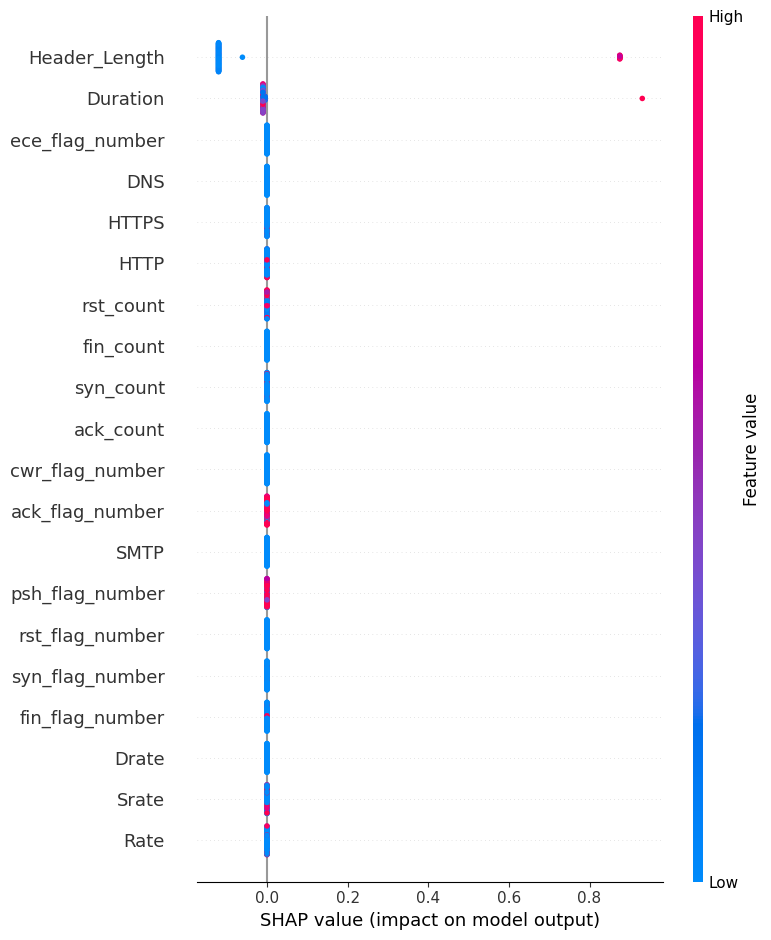

In [ ]:
#3
import shap

# Subset of test data for SHAP
subset_size = 100
subset_indices = np.random.choice(X_test.shape[0], subset_size, replace=False)
X_test_subset = X_test.iloc[subset_indices]

# Initialize SHAP KernelExplainer
explainer = shap.KernelExplainer(catboost_clf.predict, X_test_subset)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_subset)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test_subset)

In [ ]:
#4
# Predict anomalies for the subset
y_pred_subset = catboost_clf.predict(X_test_subset)

# Combine SHAP and predictions
shap_df = pd.DataFrame(shap_values, columns=[f"Feature_{i}" for i in range(X_test_subset.shape[1])])
shap_df['Prediction'] = y_pred_subset
shap_df['True_Label'] = y_test.iloc[subset_indices].values

# Save SHAP results
output_path = '/content/drive/My Drive/IoMT/Benign/catboost_shap_results_benign.csv'
shap_df.to_csv(output_path, index=False)

print("SHAP explanations and predictions saved to:", output_path)

SHAP explanations and predictions saved to: /content/drive/My Drive/IoMT/Benign/catboost_shap_results_benign.csv


#MQTT dos publish Data

In [ ]:
#1
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from catboost import CatBoostClassifier

# Define paths for training dataset and model saving
train_file_path = '/content/drive/My Drive/IoMT/MQTT Attacks/MQTT-DoS-Publish_Flood_train.pcap.csv'
test_file_path = '/content/drive/My Drive/IoMT/MQTT Attacks/MQTT-DoS-Publish_Flood_test.pcap.csv'
model_path = '/content/drive/My Drive/IoMT/MQTT Attacks/catboost_MQTT-DoS-Publish_Flood_model.cbm'

# Load datasets
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# Check for missing values and drop them
train_data = train_data.dropna()
test_data = test_data.dropna()

# Normalize the dataset using StandardScaler
scaler = StandardScaler()
train_data_normalized = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns)
test_data_normalized = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)

# Identify columns for anomaly detection
columns_to_check = ['Rate', 'Duration', 'Header_Length', 'Srate', 'Drate']  # Customize based on domain knowledge

# Calculate Z-scores for anomaly detection
z_scores_train = np.abs(train_data_normalized[columns_to_check].apply(lambda x: (x - x.mean()) / x.std()))
z_scores_test = np.abs(test_data_normalized[columns_to_check].apply(lambda x: (x - x.mean()) / x.std()))

# Define threshold for anomaly (e.g., 3 standard deviations from the mean)
threshold = 3

# Create an 'is_anomaly' column based on z-scores
train_data_normalized['is_anomaly'] = (z_scores_train > threshold).any(axis=1).astype(int)
test_data_normalized['is_anomaly'] = (z_scores_test > threshold).any(axis=1).astype(int)

# Separate features (X) from the target ('is_anomaly')
X_train = train_data_normalized.drop('is_anomaly', axis=1)
y_train = train_data_normalized['is_anomaly']
X_test = test_data_normalized.drop('is_anomaly', axis=1)
y_test = test_data_normalized['is_anomaly']

# Initialize CatBoostClassifier
catboost_clf = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=10, loss_function='Logloss', eval_metric='Accuracy', verbose=100, random_seed=42)

# Train the CatBoost model
catboost_clf.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# Save the trained model
catboost_clf.save_model(model_path)

# Predict on the test set
y_pred = catboost_clf.predict(X_test)

# Evaluate the model
print("Test Set Performance")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Save the results with anomaly column added
test_data_normalized['predicted_anomaly'] = y_pred
output_path = '/content/drive/My Drive/IoMT/MQTT Attacks/MQTT-MQTT-DoS-Publish_Flood_catboost.csv'
test_data_normalized.to_csv(output_path, index=False)

# Print a summary of detected anomalies
anomalies_count = test_data_normalized['predicted_anomaly'].sum()
print(f'Number of anomalies detected in the test data: {anomalies_count}')

0:	learn: 0.9958085	test: 0.9864785	best: 0.9864785 (0)	total: 165ms	remaining: 1m 22s
100:	learn: 1.0000000	test: 0.9887125	best: 0.9888301 (19)	total: 17.1s	remaining: 1m 7s
200:	learn: 1.0000000	test: 0.9885949	best: 0.9888301 (19)	total: 37.4s	remaining: 55.6s
300:	learn: 1.0000000	test: 0.9887125	best: 0.9888301 (19)	total: 56.4s	remaining: 37.3s
400:	learn: 1.0000000	test: 0.9887125	best: 0.9888301 (19)	total: 1m 5s	remaining: 16.3s
499:	learn: 1.0000000	test: 0.9887125	best: 0.9888301 (19)	total: 1m 15s	remaining: 0us

bestTest = 0.9888300999
bestIteration = 19

Shrink model to first 20 iterations.
Test Set Performance
[[8387    3]
 [  92   23]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8390
           1       0.88      0.20      0.33       115

    accuracy                           0.99      8505
   macro avg       0.94      0.60      0.66      8505
weighted avg       0.99      0.99      0.99      8505

Number of an

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import numpy as np

# Define GAN components
def build_generator(input_dim, output_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dense(256, activation='relu'),
        Dense(output_dim, activation='tanh')  # Typically used for continuous data
    ])
    return model

def build_discriminator(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')  # For binary classification (real/fake)
    ])
    return model

# Set dimensions
input_dim = X_train.shape[1]  # Number of features
output_dim = X_train.shape[1]  # The generator should output the same shape as input

# Build models
generator = build_generator(input_dim, output_dim)
discriminator = build_discriminator(output_dim)

# Compile discriminator
discriminator.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

# Combine models to form GAN
gan = Sequential([generator, discriminator])
gan.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy')

# Training GAN
num_epochs = 100
batch_size = 64

# Ensure that X_train is a numpy array, if it's a DataFrame
if isinstance(X_train, pd.DataFrame):
    X_train = X_train.values

# GAN Training Loop
for epoch in range(num_epochs):
    # Randomly pick a batch of real data from X_train
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_data = X_train[idx]

    # Generate fake data
    noise = np.random.normal(0, 1, (batch_size, input_dim))  # Noise vector
    fake_data = generator.predict(noise)

    # Train discriminator on real and fake data
    d_loss_real = discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))  # Label real data as 1
    d_loss_fake = discriminator.train_on_batch(fake_data, np.zeros((batch_size, 1)))  # Label fake data as 0

    # Train the generator via the GAN
    noise = np.random.normal(0, 1, (batch_size, input_dim))  # Noise vector
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))  # We want the generator to produce data that the discriminator labels as real

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Discriminator Loss: {d_loss_real[0] + d_loss_fake[0]}, Generator Loss: {g_loss}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 0, Discriminator Loss: 1.6065716743469238, Generator Loss: [array(0.75741327, dtype=float32), array(0.75741327, dtype=float32), array(0.4453125, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 10, Discriminator Loss: 1.4055426120758057, Generator Loss: [array(0.7083698, dtype=float32), array(0.7083698, dtype=float32), array(0.45170453, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━

  0%|          | 0/100 [00:00<?, ?it/s]

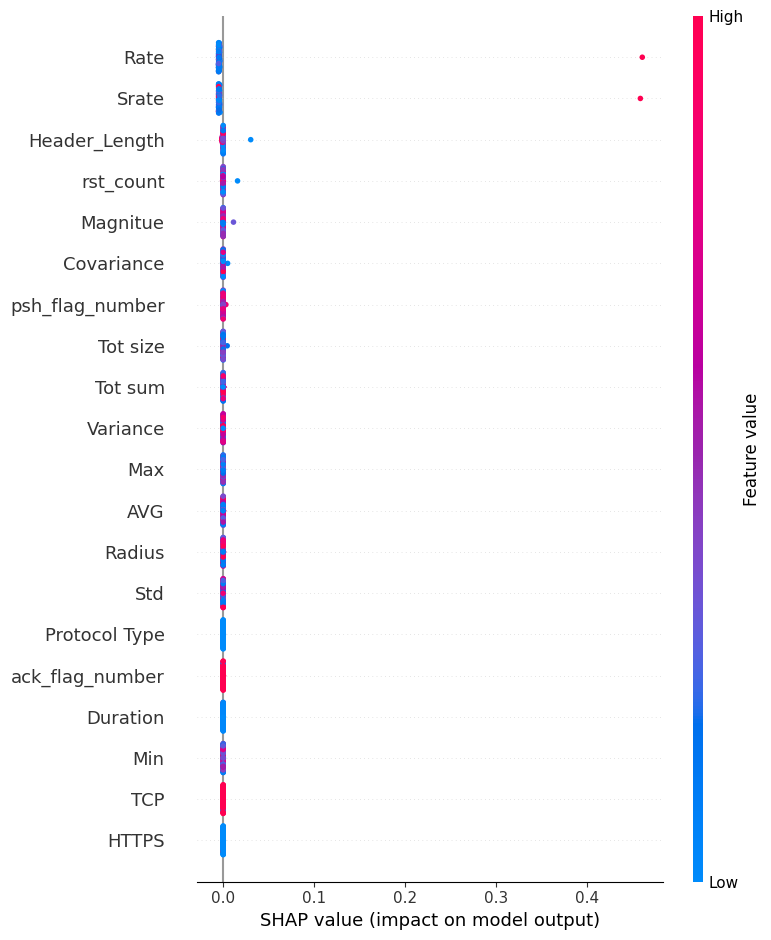

In [ ]:
#3
import shap
import numpy as np

# Select a subset of 100 instances for SHAP analysis (you can change subset size)
subset_size = 100
subset_indices = np.random.choice(X_test.shape[0], subset_size, replace=False)

# Use .iloc to index rows by their positions
X_test_subset = X_test.iloc[subset_indices]

# Initialize SHAP explainer
explainer = shap.KernelExplainer(catboost_clf.predict, X_test_subset)

# Generate SHAP values for the subset
shap_values = explainer.shap_values(X_test_subset)

# Visualize the SHAP summary plot
shap.summary_plot(shap_values, X_test_subset)

In [ ]:
#4
# Predict on the subset
y_pred_subset = catboost_clf.predict(X_test_subset)

# Combine SHAP values and predictions into a DataFrame
shap_df = pd.DataFrame(shap_values, columns=[f"Feature_{i}" for i in range(X_test_subset.shape[1])])
shap_df['Prediction'] = y_pred_subset
shap_df['True_Label'] = y_test_subset

# Save the combined SHAP and predictions
output_path = '/content/drive/My Drive/IoMT/MQTT Attacks/catboost_shap_MQTT-DoS-Publish_Flood_combined_results.csv'
shap_df.to_csv(output_path, index=False)

print("Combined SHAP and predictions saved to:", output_path)

NameError: name 'y_test_subset' is not defined